In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv('data_encoded.csv')

In [34]:
X = df.drop('overall_rating', axis=1)
y = df['overall_rating']

In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# Minkowski Distance (p = 2)

In [50]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5, p=2)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [51]:
y_pred = knn.predict(X_test_scaled)
y_train_pred = knn.predict(X_train_scaled)

In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Training Set:')
print('MAE:', mean_absolute_error(y_train, y_train_pred))
print('MSE:', mean_squared_error(y_train, y_train_pred))
print('R2 score:', r2_score(y_train, y_train_pred))

print()

print('Test Set:')
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 score:', r2_score(y_test, y_pred))

Training Set:
MAE: 1.2656636576395854
MSE: 2.67358074222668
R2 score: 0.9450990324123522

Test Set:
MAE: 1.4973424703326095
MSE: 3.8302724385759648
R2 score: 0.9193593395771321


# Minkowski Distance (p = 1)

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn = KNeighborsRegressor(n_neighbors=5, p=1)
knn.fit(X_train_scaled, y_train)

KNeighborsRegressor(p=1)

In [37]:
y_pred = knn.predict(X_test_scaled)
y_train_pred = knn.predict(X_train_scaled)

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Training Set:')
print('MAE:', mean_absolute_error(y_train, y_train_pred))
print('MSE:', mean_squared_error(y_train, y_train_pred))
print('R2 score:', r2_score(y_train, y_train_pred))

print()

print('Test Set:')
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 score:', r2_score(y_test, y_pred))

Training Set:
MAE: 0.9946004680708795
MSE: 1.6926813774657306
R2 score: 0.9652414292290776

Test Set:
MAE: 1.1760655189704163
MSE: 2.4404613070366037
R2 score: 0.948619735360377


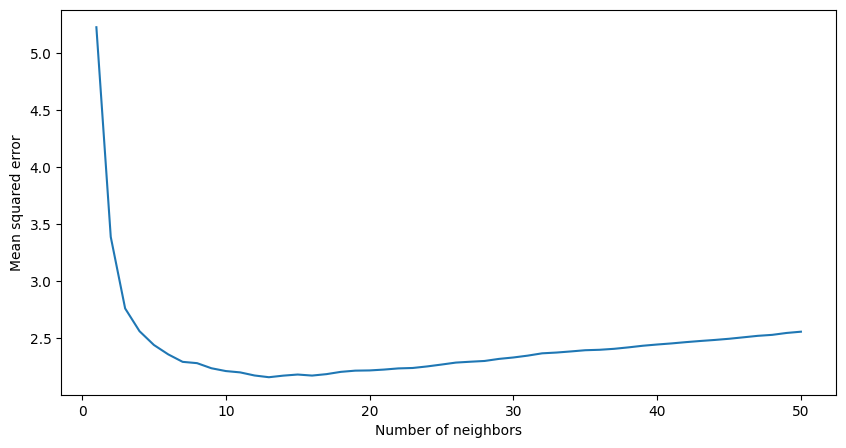

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

losses = []
min_loss = float('inf')
min_k = 0

for i in range(1, 51):
    pipe = Pipeline([('scaler', StandardScaler()), 
                     ('knn', KNeighborsRegressor(n_neighbors=i, p=1))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    loss = np.mean((y_pred - y_test)**2)
    if loss < min_loss:
        min_loss = loss
        min_k = i
    losses.append(loss)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 51), losses)
plt.xlabel('Number of neighbors')
plt.ylabel('Mean squared error')
plt.show()

In [40]:
print('Best k:', min_k)
print('Minimum loss:', min_loss)

Best k: 13
Minimum loss: 2.1576715882376796


In [41]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=min_k, p=1))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
y_train_pred = pipeline.predict(X_train)

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print('Training Set:')
print('MAE:', mean_absolute_error(y_train, y_train_pred))
print('MSE:', mean_squared_error(y_train, y_train_pred))
print('R2 score:', r2_score(y_train, y_train_pred))

print()

print('Test Set:')
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R2 score:', r2_score(y_test, y_pred))

Training Set:
MAE: 1.0338386955739014
MSE: 1.8903797190387732
R2 score: 0.9611817686879137

Test Set:
MAE: 1.093791383278263
MSE: 2.1576715882376796
R2 score: 0.9545734501549363


In [43]:
X.shape

(17947, 58)

In [44]:
y.shape

(17947,)

In [45]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipeline, X, y, cv=10, scoring='neg_mean_absolute_error')
print('Cross-validation mean absolute error:', -scores.mean())

Cross-validation mean absolute error: 1.0839197247974883


In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

cv = 5

r2_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='r2', n_jobs=-1)
print(f"R^2 scores cho {cv}-fold cross-validation: {r2_scores}")
print(f"R^2 trung bình: {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print()

mse_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
mse_scores = -mse_scores
print(f"MSE cho {cv}-fold cross-validation: {mse_scores}")
print(f"MSE trung bình: {mse_scores.mean():.3f}" + u"\u00B1" + f" {mse_scores.std():.3f}")
print()

mae_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=-1)
mae_scores = -mae_scores
print(f"MAE cho {cv}-fold cross-validation: {mae_scores}")
print(f"MAE trung bình: {mae_scores.mean():.3f} ± {mae_scores.std():.3f}")

R^2 scores cho 5-fold cross-validation: [0.9590565  0.95797239 0.95198627 0.95559233 0.95338317]
R^2 trung bình: 0.956 ± 0.003

MSE cho 5-fold cross-validation: [2.00717476 1.99022103 2.33395764 2.20429452 2.18089626]
MSE trung bình: 2.143± 0.129

MAE cho 5-fold cross-validation: [1.06370259 1.0669595  1.12598324 1.11093727 1.09932057]
MAE trung bình: 1.093 ± 0.024


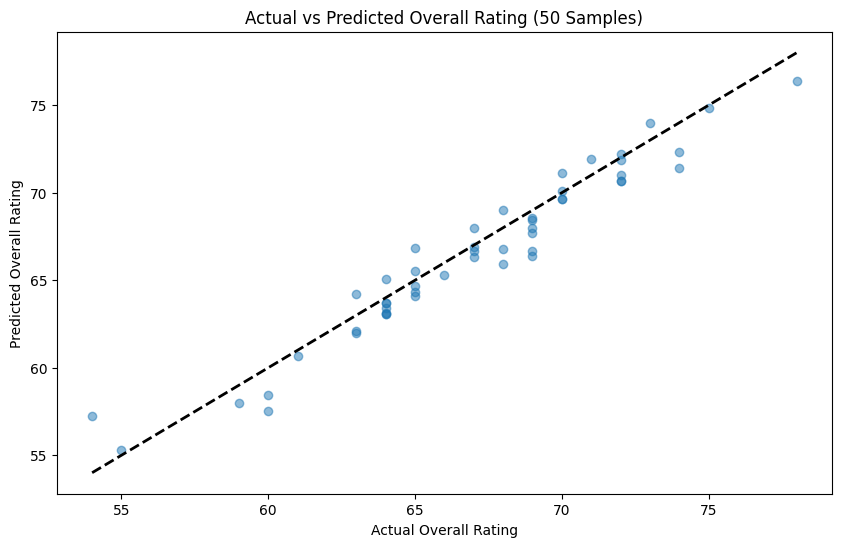

In [49]:
import matplotlib.pyplot as plt

# Select 20 samples
y_test_sample = y_test[:50]
y_pred_sample = y_pred[:50]

plt.figure(figsize=(10, 6))
plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
plt.plot([y_test_sample.min(), y_test_sample.max()], [y_test_sample.min(), y_test_sample.max()], 'k--', lw=2)
plt.xlabel('Actual Overall Rating')
plt.ylabel('Predicted Overall Rating')
plt.title('Actual vs Predicted Overall Rating (50 Samples)')
plt.show()